In [57]:
import os
import requests, json
import torch
import seaborn as sns
from random import sample
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [33]:
sns.set()
%config InlineBackend.figure_format = 'retina'

In [30]:
DATA_URL = "https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/datasets/russian_names.txt"
raw_data = json.loads(requests.get(DATA_URL).content)
names = list(raw_data['payload']['blob'].values())[0]
names[:3]

['Ababko', 'Abaev', 'Abagyan']

Text(0.5, 1.0, 'Name Length Distribution')

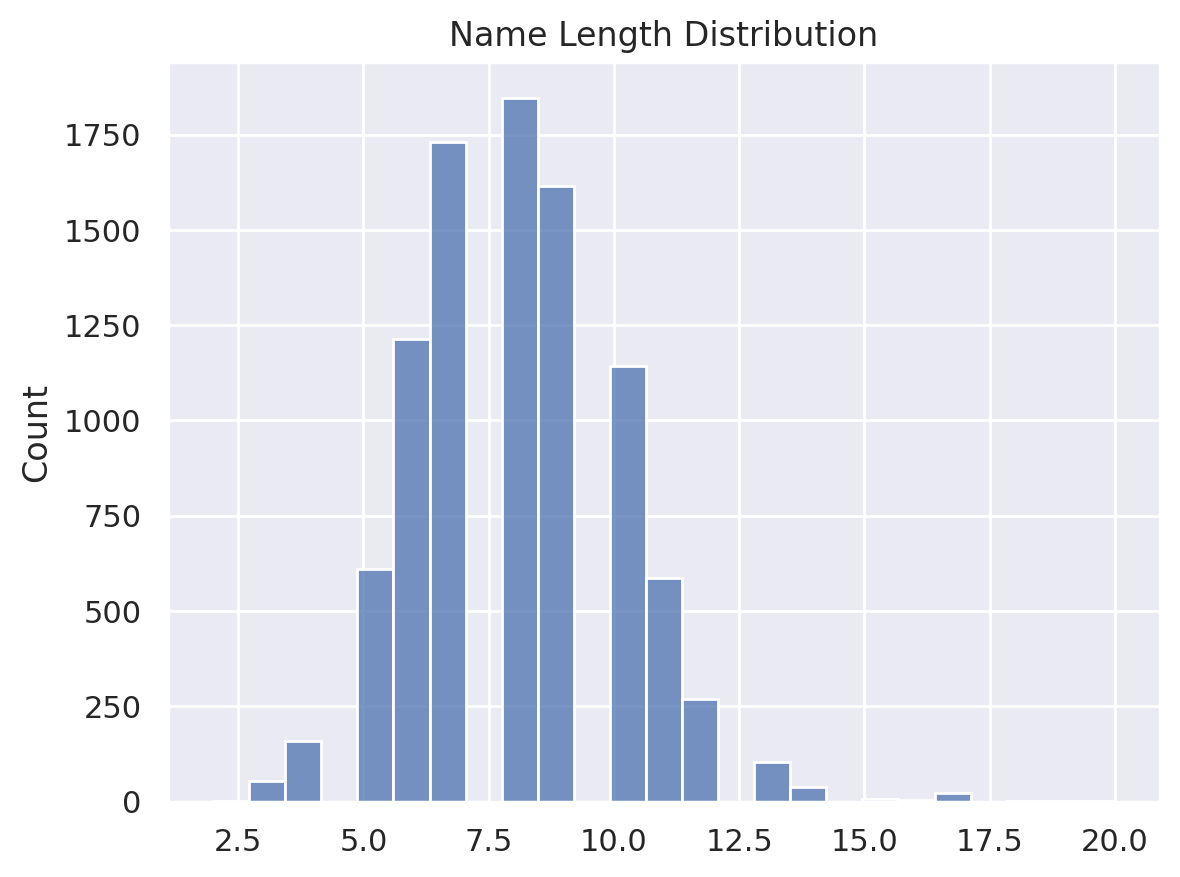

In [38]:
sns.histplot(list(map(len, names)), bins=25).set_title("Name Length Distribution")

In [40]:
tokens = list(set(''.join(names)))
num_of_tokens = len(tokens)
tokens[:5]

['u', 'm', 'v', 'g', ' ']

In [41]:
token2id = {token:idx for idx, token in enumerate(tokens)}
assert len(token2id)==num_of_tokens, "The length of vocabulary has to be equal to number of tokens"

In [59]:
def to_matrix(data: list, token2id: dict, max_length: int,
              dtype: str = 'int32', batch_first: bool = True):
    """Transform list of names into a matrix representation"""
    if not max_length:
        max_length = max(map(len, data))

    data_idx = np.zeros([len(data), max_length], dtype) + token2id[' ']
    for i in range(len(data)):
        current_word = [token2id[char] for char in data[i]]
        data_idx[i, :len(current_word)] = current_word # align our word to the matrix

    if not batch_first:
        return np.transpose(data_idx)

    return data_idx

# Creating a RNN model

In [123]:
class SimpleRNN(nn.Module):
    """The trivial implementation of the RNN architecture"""
    def __init__(self, num_of_tokens: int,
                 embedding_size: int,
                 rnn_num_of_units: int):
        super().__init__()
        self.num_of_tokens = num_of_tokens
        self.embedding_size = embedding_size
        self.rnn_num_of_units = rnn_num_of_units

        self.embedding = nn.Embedding(num_of_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_of_units, rnn_num_of_units)
        self.rnn2logits = nn.Linear(rnn_num_of_units, num_of_tokens)

    def forward(self, x, prev_hidden_state):
        """Compute the next hidden state"""
        embedded_x = self.embedding(x)
        concatenated_vec = torch.cat([embedded_x, prev_hidden_state], dim = 1)
        next_hidden_state = self.rnn_update(concatenated_vec)
        next_hidden_state = nn.functional.tanh(next_hidden_state)
        logits = self.rnn2logits(next_hidden_state)

        return next_hidden_state, nn.functional.log_softmax(logits, dim = -1)

    def initial_state(self, batch_size: int):
        """Initialize hidden state layer"""
        return torch.autograd.Variable(torch.zeros(batch_size, self.rnn_num_of_units))

In [107]:
def rnn_loop(model: SimpleRNN, batch_idx):
    """"""
    batch_size, max_length = batch_idx.size()
    h_state = model.initial_state(batch_size)
    log_probs = []

    for x_t in batch_idx.transpose(0, 1):
        h_state, log_prob = model(x_t, h_state)
        log_probs+=[log_prob]

    return torch.stack(log_probs, dim = 1)

In [124]:
model = SimpleRNN(num_of_tokens = len(tokens),
                  embedding_size = 16,
                  rnn_num_of_units = 64)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2)
history = []
MAX_LENGTH = max(map(len, names))

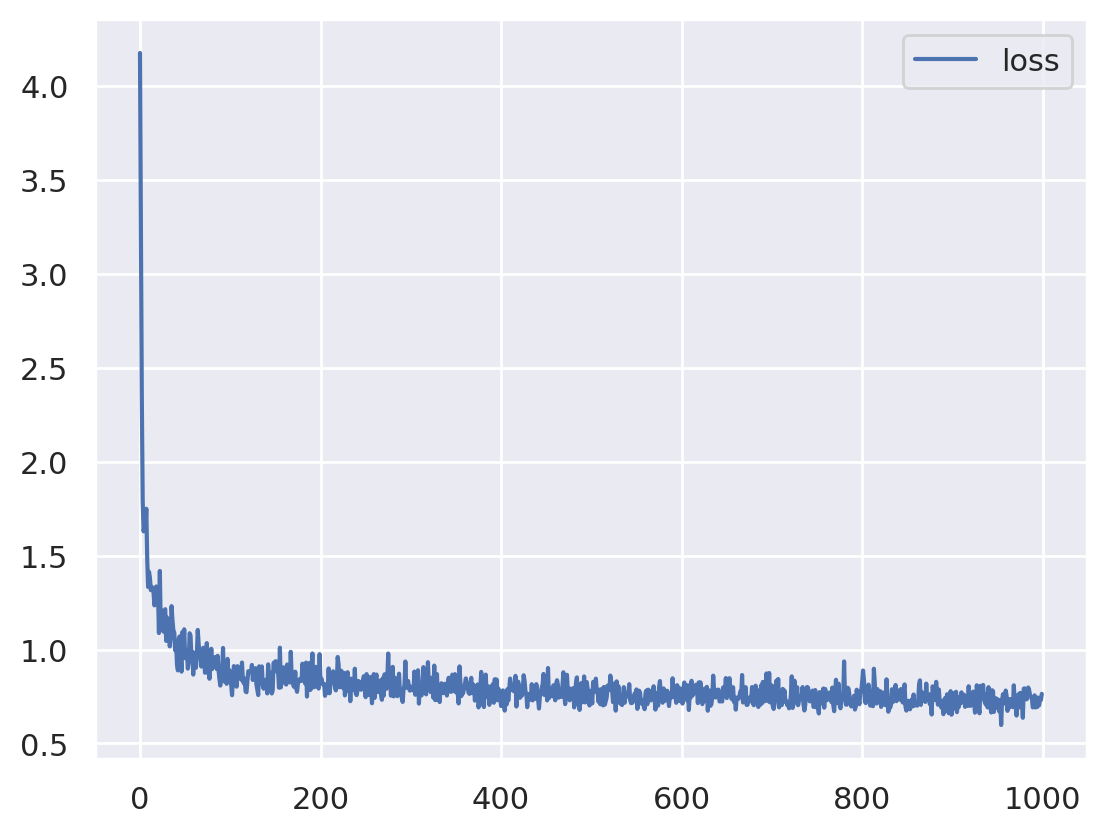

In [125]:
for i in range(1000):
    batch_ix = to_matrix(sample(names, 32),
                         token2id,
                         max_length = MAX_LENGTH)

    batch_ix = torch.tensor(batch_ix,
                            dtype=torch.int64)

    logp_seq = rnn_loop(model, batch_ix)

    # Loss computation
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [132]:
def generate_sample(char_rnn: SimpleRNN, max_length: int,
                    seed_phrase: str = ' ', temperature: float = 1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token2id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = nn.functional.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [151]:
for _ in range(11):
    print(generate_sample(model, max_length = 10,
                          temperature = 1.2, seed_phrase = " F"))

 Fir      
 Firs     
 Farev    
 Firchveev
 FeefGoy  
 Fer      
 Filserov 
 Fogoy    
 Farseev  
 Firslenko
 Firsky   
